# <center>Discretizing reading categories</center>

<center>last changed July 12, 2019</center>

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.porter import *

In [49]:
pd.read_csv(
    'MoreFiles/categories_edited.csv', 
    header=None
).to_csv(
    'MoreFiles/categories.csv', 
    sep='|', 
    index=False
)

In [50]:
f = [
    list(r[1]) 
    for r in pd.read_csv(
        'MoreFiles/categories.csv', 
        sep='|'
    ).iterrows()
]
f = [ln for ln in f if ln.count(np.nan) != len(ln)]

In [55]:
delimiter_idx = [
    tuple([idx, l[0]]) 
    for idx, l in enumerate(f) 
    if pd.isnull(l[1])
]

In [85]:
start = 0
grp_name_to_lns = {}
for n, tpl in enumerate(delimiter_idx[:-1]):
    grp_name = tpl[1]
    nxt = delimiter_idx[n+1][0]
    grp_name_to_lns[grp_name] = tuple([start, nxt])
    start = nxt
grp_name_to_lns[delimiter_idx[-1][1]] = tuple([start, len(f) - 1])

In [97]:
grp_name_to_subgrps_to_lns = {}
for grp_name, lns in grp_name_to_lns.items():
#     print('\n', grp_name)
    subgrp_name_to_notes = {}
    for x in f[lns[0] + 1:lns[1]]:
        subgrp_name = x[0]
        for note in x[1:]:
            if not pd.isnull(note):
                reg = note.strip().lower().replace(';', '')
                try:
                    subgrp_name_to_notes[subgrp_name].append(reg)
                except KeyError:
                    subgrp_name_to_notes[subgrp_name] = [reg]
    grp_name_to_subgrps_to_lns[grp_name] = subgrp_name_to_notes

In [110]:
obs_full = list(pd.read_csv(
    'DataFromFirstEmail/20190118_reading_specialists.csv'
).OBS)
obs_short = [
    [y.strip() for y in x.lower().replace('$obs:', '').strip().split(';')] 
    for x in obs_full
]
corpus = [
    x.replace('.', '').replace(',', '').replace('/', '') 
    for y in obs_short 
    for x in y 
    if x
]

In [114]:
better_epr_iter = [
    tuple([grp_name, subgrp, ln])
    for grp_name, subgrps_to_lns in grp_name_to_subgrps_to_lns.items()
    for subgrp, lns in subgrps_to_lns.items()
    for ln in lns
]

exact matches $\downarrow$

In [120]:
from collections import Counter

In [149]:
cntr = Counter()
for obs in corpus:
    for epr_cluster in better_epr_iter:
        if obs == epr_cluster[-1]:
            cntr[epr_cluster[:-1]] += 1
cntr_lst = sorted(
    [
        tuple([' - '.join(k), v]) 
        for k, v in dict(cntr).items()
    ], 
    key=lambda kv: -kv[1]
)
_c = list(zip(*cntr_lst))
k, v = _c[0], _c[1]

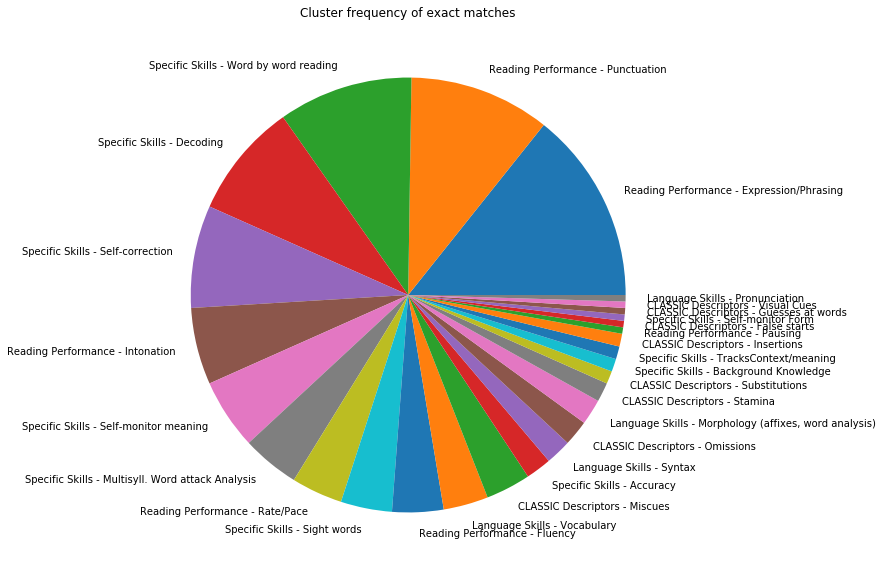

In [159]:
plt.figure(figsize=(10,10))
plt.title('Cluster frequency of exact matches')
plt.pie(np.array(v), labels=k)
plt.show()